This notebook recreates the following example using BET:  
http://madsjulia.github.io/Mads.jl/Examples/infogap/  
See the introduction of the documentation therein for more information about the problem setup. 

Author: Michael Pilosov  
Date: 06-15-2017

In [1]:
# Import modules
import numpy as np
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
import bet.sample as samp
import bet.sampling.basicSampling as bsam
from myModel import my_model

import time
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
num_input_samples = 5E5 # Note 20,000 samples is similar to what the regular grid would use
randomSampling = True # random or regular sampling?
grid_factor = 1 # for regular sampling only. how many per interval.

Define reference parameter. Recall that  
$$
y(t) = a t^n + bt + c
$$

The convention of ordering for our parameter $\lambda$ that we will use is  
$$
\lambda = [a, b, c, n]
$$

Since the data we are trying to match up for $t = [1,2,3,4]$ is $y(t) = [1,2,3,4]$, then we have two cases for $n$ that yield the following analytic solutions:  

$$ 
n = 0 \implies a+c=0, b=1 \\
n = 1 \implies a+b=1, c=0
$$

**Our QoI will be the RSS between the model and the observations**

We then pick any viable reference parameter and map it to our 1-D output space.

In [18]:
a = 10*np.random.rand()-5 # choose any a between -5 and 5
# pick any one of the analytical solutions [a,b,c,n]
ref_param = np.array([[a, 1.0, -a, 0.0]])
ref_param = np.array([[5,5,2,3]])
# ref_param = np.array([[a, 1.0-a, 0.0, 1.0]])
Q_ref =  my_model(np.array(ref_param))
print ref_param[0], '=>', Q_ref[0]

[5 5 2 3] => 139066.0


Next we define the sampler that will be used to create the discretization object, initialize 4-dimensional input parameter sample set object, and set up the parameter space domain (our prior/ansatz is uniform over this space) and generate the (random or regular) samples on which we will later form our probability measure. 

In [5]:
sampler = bsam.sampler(my_model)
input_samples = samp.sample_set(4)
input_samples.set_domain(np.array([ [-10.0, 10.0],
                                    [-10.0, 10.0], 
                                    [-5.0, 5.0], 
                                    [-3.0, 3.0] ]))

if randomSampling is True:
    input_samples = sampler.random_sample_set('random', input_samples, num_samples=num_input_samples)
else:
    # if regular sampling, use the integer grid in uncertainty box. 24,000 samples.
    input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=grid_factor*np.array([20, 20, 10, 6])) 


A standard Monte Carlo (MC) assumption is that every Voronoi cell has the same volume. If a regular grid of samples was used, then the standard MC assumption is true. If the number of random samples is large enough for the dimension of the parameter space, the MC assumption is _practically_ true. To have accurate volumes of the randomly generated Voronoi cells, we can use emulation. 

In [6]:
MC_assumption = True
start_time = time.time()
# Estimate volumes of Voronoi cells associated with the parameter samples
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=num_input_samples*50.0)
else:
    input_samples.estimate_volume_mc()

# Create the discretization object using the input samples
my_discretization = sampler.compute_QoI_and_create_discretization(input_samples)
end_time = time.time()

In [8]:
print 'time elapsed:', (end_time - start_time)/60
print 'number of unique volumes:', np.unique(my_discretization._input_sample_set._volumes).shape[0]

 time elapsed: 0.00152263243993
number of unique volumes: 1


Next, we define a distribution on our output space, which is user-defined as a propogation of a grid (of resolution `input_res` per unit interval of uncertainty) in the parameter space mapped forward by the model. We create a simple-function approximation to this distribution by partitioning it into `output_disc_cells` even intervals.

Finally, we calculate the probability measure over the parameter space $\Lambda$.

#### Create output density

In [10]:
input_res = 4
density_samples = samp.sample_set(4)
density_samples.set_domain(np.array([ [-10.0, 10.0],
                                    [-10.0, 10.0], 
                                    [-5.0, 5.0], 
                                    [-3.0, 3.0] ]))
density_samples = sampler.regular_sample_set(density_samples, num_samples_per_dim=input_res*np.array([20, 20, 10, 6]))
density_discretization = sampler.compute_QoI_and_create_discretization(density_samples,
                                            savefile='densityRSSQoI.tar.gz')

#### Load Density once created

In [11]:
density_discretization = samp.load_discretization('densityRSSQoI.tar.gz')

In [25]:
output_disc_cells = 50
data_partition_set = np.array([np.linspace(0,np.max(my_discretization._output_sample_set._values),output_disc_cells) ]).transpose()

simpleFunP.user_partition_user_distribution(data_set = my_discretization, 
                                 data_partition_set = data_partition_set,
                                 data_distribution_set = density_discretization)
    
calculateP.prob(my_discretization)

In [26]:
# Extrapolate to t=5 # 
print 'num unique prob events: ', len(np.unique(input_samples._probabilities))
print 'total nonzero probability samples: ', sum(input_samples._probabilities!=0)
threshvec = np.sort(np.unique(input_samples._probabilities))

num unique prob events:  40
total nonzero probability samples:  499809


In [27]:
thresh = threshvec[1] # threshold, [-1] => highest probability only. [1] => nonzero
print 'thresh: ', thresh
above_thresh = input_samples._probabilities>=thresh
print 'num samples with highest probs: ', sum(above_thresh)
print 'which represents: ', 100*sum(input_samples._probabilities[above_thresh]), '%% of the total probability'

thresh:  1.83761760753e-08
num samples with highest probs:  499809
which represents:  100.0 %% of the total probability


In [28]:
# range of nonzero probability samples (full pushforward, posterior).
samples_nonzero = input_samples._values[input_samples._probabilities>0]
t = 5.0
print 'Range of nonzero prob events: \n'
extrapolation = samples_nonzero[:,0]*(t**samples_nonzero[:,3]) + samples_nonzero[:,1]*t + samples_nonzero[:,2]
print 'Model at t=5, (min, max):', np.min(extrapolation), np.max(extrapolation) 
print '\t\t   range:', np.max(extrapolation)-np.min(extrapolation)

# # range of just the highest probability samples.
# samples_thresh = input_samples._values[above_thresh]
# print '\nRange of highest prob events: \n'
# extrapolation = samples_thresh[:,0]*(t**samples_thresh[:,3]) + samples_thresh[:,1]*t + samples_thresh[:,2]
# print 'Model at t=5, (min, max):', np.min(extrapolation), np.max(extrapolation) 
# print '\t\t   range:', np.max(extrapolation)-np.min(extrapolation)

# if output_disc_cells_per_dim > 1:
#     # range of the rest (nonzero but below thresh)
#     nonzero_below_thresh = np.where( (input_samples._probabilities>0) & (input_samples._probabilities<thresh) )[0]
#     samples_subset = input_samples._values[nonzero_below_thresh]
#     print '\nRange of the rest: \n'
#     extrapolation = samples_subset[:,0]*(t**samples_subset[:,3]) + samples_subset[:,1]*t + samples_subset[:,2]
#     print 'Model at t=5, (min, max):', np.min(extrapolation), np.max(extrapolation) 
#     print '\t\t   range:', np.max(extrapolation)-np.min(extrapolation)


Range of nonzero prob events: 

Model at t=5, (min, max): -1189.45895661 1192.65808986
		   range: 2382.11704647


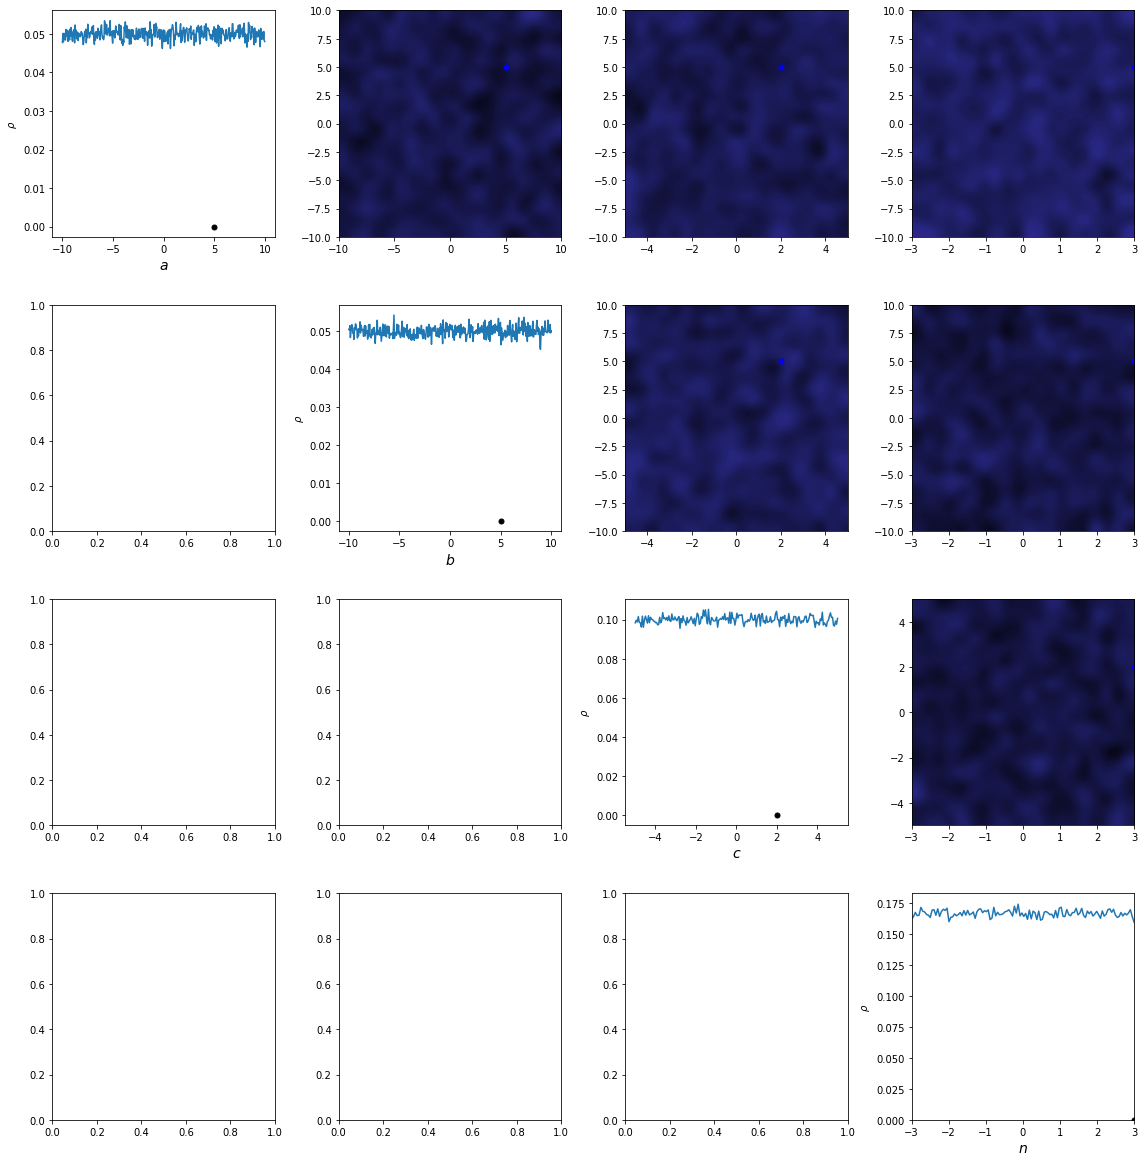

In [38]:
plot_disc = 20 # plotting discretization

# calculate 2d marginal probs
(bins2D, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                                                        nbins = plot_disc*np.ones(4))

# smooth 2d marginals probs (optional)
# marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=0.2)

# plot 2d marginals probs
plotP.plot_2D_marginal_probs(marginals2D, bins2D, input_samples, filename = "linearMap",
                             lam_ref=ref_param[0], file_extension = ".eps", plot_surface=False)

# calculate 1d marginal probs
(bins1D, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
#                                                         nbins = plot_disc*np.ones(4))
                                                        nbins = plot_disc*np.array([20, 20, 10, 6]))
# smooth 1d marginal probs (optional)
# marginals1D = plotP.smooth_marginals_1D(marginals1D, bins1D, sigma=0.1)

plt.rcParams['figure.figsize'] = (16, 16)
lambda_label = ['a','b','c','n']
f, ax = plt.subplots(4,4)
for i in xrange(4):
    for j in xrange(4):
        lam_domain = input_samples.get_domain()
        if i==j:
            x_range = np.linspace(lam_domain[i, 0], lam_domain[i, 1],
                    len(bins1D[i])-1)
            ax[i,j].plot(x_range, marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))
#             ax[i,j].set_ylim([0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            plt.axis([lam_domain[i][0], lam_domain[i][1], 
                      0, 1.05*np.max(marginals1D[i]/(bins1D[i][1]-bins1D[i][0]))])
            ax[i,j].plot(ref_param[0,i], 0.0, 'ko', markersize=5)
            ax[i,j].set_ylabel(r'$\rho$')
            ax[i,j].set_xlabel(r'$%s$'%lambda_label[i],fontsize=14)
            
        elif i<j:
#             ax[i,j].scatter(marginals1D[i], marginals1D[j])
            boxSize = (bins2D[i][1]-bins2D[i][0])*(bins2D[j][1]-bins2D[j][0])
            ax[i,j].imshow(marginals2D[(i,j)]/boxSize, 
                          interpolation='bicubic', cmap=cm.CMRmap_r, 
                          extent=[lam_domain[j][0], lam_domain[j][1],
                          lam_domain[i][0], lam_domain[i][1]], origin='lower',
                          vmax=marginals2D[(i, j)].max()/boxSize, vmin=0, aspect='auto')
            ax[i,j].plot(ref_param[0,j], ref_param[0,i], 'bo', markersize=5)
            plt.axis([lam_domain[j][0], lam_domain[j][1], 
                      lam_domain[i][0], lam_domain[i][1]])
            plt.tight_layout()
#             ax[i,j].set_ylabel(r'$%s$'%lambda_label[j])
        
f.subplots_adjust(hspace=0.3)
plt.show()

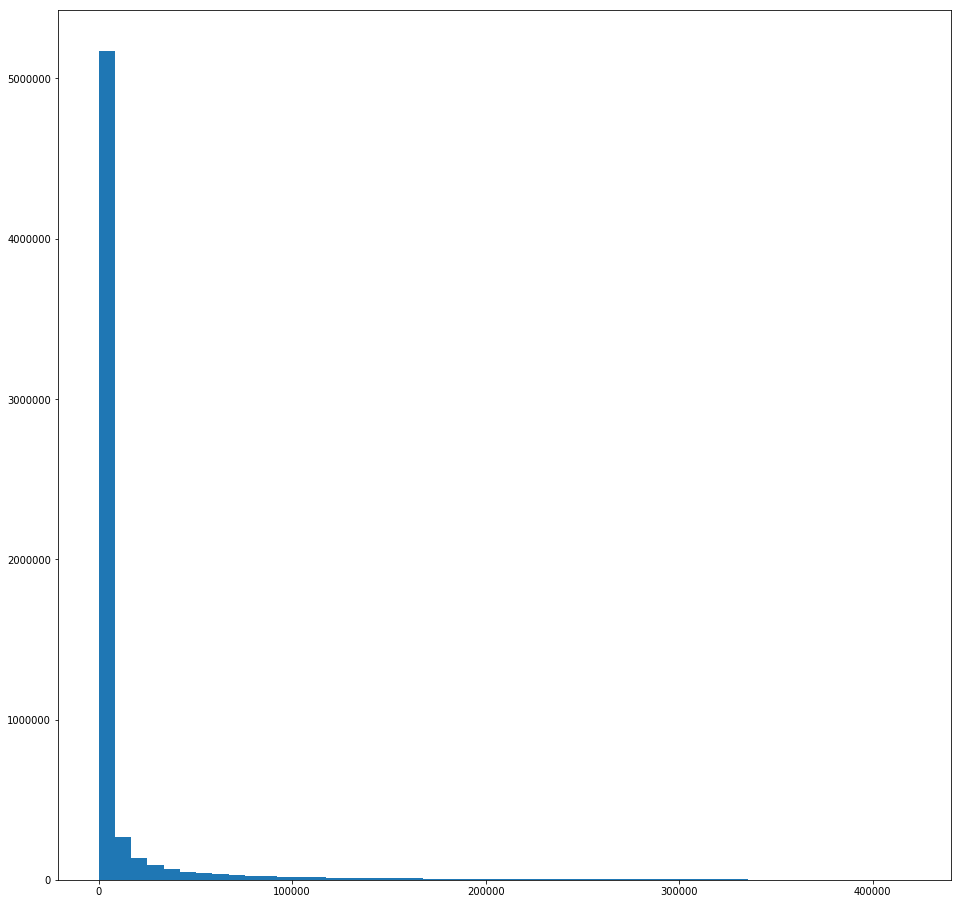

In [39]:
plt.hist(density_discretization._output_sample_set._values,50)
plt.show()

In [ ]:
# plt.scatter(marginals1D[0],marginals1D[3])
# plt.show()
np.unique(input_samples._probabilities)

In [ ]:
# print sum(my_discretization._input_sample_set._probabilities)
# print sum(my_discretization._output_probability_set._probabilities)
# print my_discretization._output_probability_set._values

# print my_discretization._output_sample_set._values